# 第四部分 模型篇 —— 集成模型

## 1、投票组合法

1）导入相关的包：

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'ieee', 'grid', 'muted'])

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

2）数据准备：

In [9]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer()
y = bc.target
X = pd.DataFrame.from_records(data=bc.data, columns=bc.feature_names)

# 转化为df
df = X
df['target'] = y

In [10]:
# 只取前3个特征
cols = [
    'mean radius',
    'mean texture',
    'mean perimeter',
]

X_train, X_test, y_train, y_test = train_test_split(X[cols],
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y)

3）使用3种算法（最近邻、逻辑回归、决策树）和3种算法投票，并查看效果：

In [11]:
clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = LogisticRegression(solver='liblinear', C=0.05, random_state=42)
clf3 = DecisionTreeClassifier(max_depth=1, random_state=42)

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe2 = Pipeline([['sc', StandardScaler()], ['clf', clf2]])

clf_labels = [
    'KNN',
    'Logistic',
    'Decision tree',
]

# weights=[1, 1, 1] 表示3种子模型使用相同的权重
voter = VotingClassifier(estimators=[('knn', pipe1), ('lr', pipe2),
                                     ('dc', clf3)],
                         voting='soft',
                         weights=[1, 1, 1])

In [12]:
for clf, label in zip([pipe1, pipe2, clf3, voter],
                      clf_labels + ['Soft Voting']):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("AUC:{:.2} (+/- {:.2}) [{}]".format(scores.mean(), scores.std(),
                                              label))



AUC:0.87 (+/- 0.035) [KNN]
AUC:0.95 (+/- 0.031) [Logistic]
AUC:0.86 (+/- 0.049) [Decision tree]
AUC:0.95 (+/- 0.024) [Soft Voting]


## 2、Bagging模型性能分析实验

### 决策树 vs Bagging决策树，看方差差异

导入相关包

In [13]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier,BaggingRegressor

划分数据集

In [14]:
# 只取前2个特征
cols = [
    'mean radius','mean texture',
]
X_train, X_test, y_train, y_test = train_test_split(X[cols],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)


构造决策分类树

In [15]:
# max_depth=None 树尽量生长
tree = DecisionTreeClassifier(max_depth=None, random_state=42)

In [16]:
# 训练模型
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracy: {:.3f}/{:.3f}'.format(
    acc_train, acc_test))

Decision tree train/test accuracy: 1.000/0.781


In [17]:
# 创造一个200课树的Bagging
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=200,
                        max_samples=0.9,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=42)

In [18]:
# 训练模型
bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)
print('Bagging tree train/test accuracy: {:.3f}/{:.3f}'.format(
    acc_train, acc_test))

Bagging tree train/test accuracy: 1.000/0.860


#### Bagging逻辑回归看偏差和方差

准备人造数据集

In [19]:
from sklearn.datasets import make_classification
Xt, yt = make_classification(n_samples=1000,
                           n_features=7,
                           n_redundant=1,
                           n_informative=6,
                           n_clusters_per_class=3,
                           n_classes=2,
                           random_state=42)

准备Bagging集成

In [20]:
clf_lr = LogisticRegression(solver='liblinear',
                            random_state=42,C=10)  #class_weight="balanced",1e9

bag = BaggingClassifier(base_estimator=clf_lr,
                        n_estimators=200,
                        max_samples=0.5,
                        #max_features=1,
                        random_state=42)

使用逻辑回归和Bagging逻辑回归

In [21]:
for clf, label in zip([clf_lr, bag], ['Logistic','Bagging Logistic']):
    scores = cross_val_score(estimator=clf,
                             X=Xt,
                             y=yt,
                             cv=10,
                             scoring='roc_auc')
    print("AUC:{:.2} (+/- {:.2}) [{}]".format(scores.mean(), scores.std(),
                                              label))

AUC:0.84 (+/- 0.031) [Logistic]
AUC:0.84 (+/- 0.031) [Bagging Logistic]


## 3、Boosting方法

### Gradient Boosting

1）准备数据

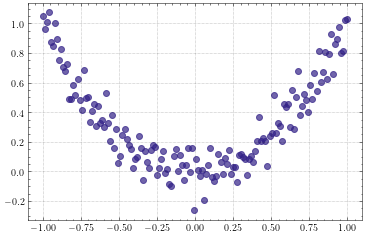

In [22]:
np.random.seed(42)

n = 150
X = np.linspace(-1, 1, n)
y = X**2 + np.random.normal(loc=0, scale=0.1, size=n)
X = X.reshape(-1, 1)

plt.scatter(X, y, alpha=0.7)
plt.show()

2）构造回归树

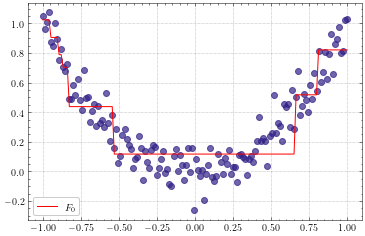

In [24]:
from sklearn.tree import DecisionTreeRegressor

dtr1 = DecisionTreeRegressor(max_depth=3)
dtr1.fit(X, y)

plt.figure()
plt.scatter(X, y, alpha=0.7)
plt.plot(X, dtr1.predict(X), 'r', label='$F_0$')
plt.legend(loc=3)
plt.show()

3）使用残差，进行第二轮拟合 (使用学习率时，$y_2 = y - \eta \hat{y}$)

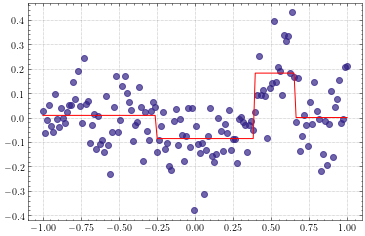

In [25]:
y2 = y - dtr1.predict(X)
dtr2 = DecisionTreeRegressor(max_depth=2)
dtr2.fit(X, y2)

plt.scatter(X, y2, alpha=0.7)
plt.plot(X, dtr2.predict(X), 'r')
plt.show()

第二轮模型为：$ F_1 = F_0 + f_1 $

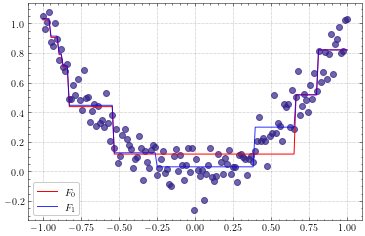

In [26]:
F_0 = dtr1.predict(X)
f_1 = dtr2.predict(X)

F_1 = F_0 + f_1
plt.scatter(X, y, alpha=0.7)
plt.plot(X, F_0, 'r', label='$F_0$')
plt.plot(X, F_1, 'b', label='$F_1$', alpha=0.8)
plt.legend()
plt.show()

4）使用残差，进行第3轮拟合：$ F_2 = F_0 + f_1 + f_2 $

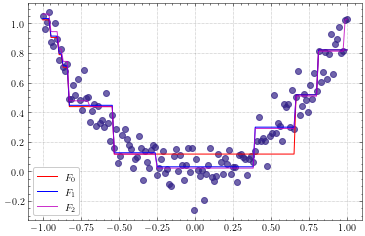

In [27]:


y3 = y2 - dtr2.predict(X)
dtr3 = DecisionTreeRegressor(max_depth=2)
dtr3.fit(X, y3)

f_2 = dtr3.predict(X)
F_2 = F_0 + f_1 + f_2

plt.scatter(X, y, alpha=0.7)
plt.plot(X, F_0, 'r', label='$F_0$')
plt.plot(X, F_1, 'b', label='$F_1$')
plt.plot(X, F_2, 'm', label='$F_2$', alpha=0.8)
plt.legend()
plt.show()

使用 GradientBoostingRegressor 将得到类似的结果

> 可以关注下sklearn 0.21 引入的新的梯度提升树直方图算法

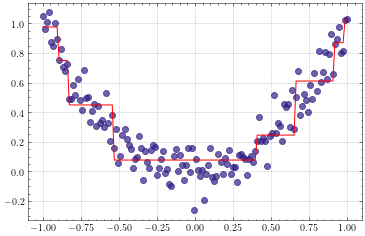

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)
gb.fit(X, y)

plt.figure()
plt.scatter(X, y, alpha=0.7)
plt.plot(X, gb.predict(X), 'r')
plt.show()

### Boosting解析

In [29]:
# 同bagging 一样的例子
import numpy as np
np.random.seed(42)
# 构造500个数据点
n = 500
X = np.array([i / n for i in range(n + 1)])
# 构造一个包含方差为 0.01 的噪音数据
y = np.array([i + np.random.normal(scale=0.1) for i in X])
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [30]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Fit regression model
params = {
    'n_estimators': 50,
    'max_depth': 1,
    'learning_rate': 0.5,
    'loss': 'ls'
}
clf = GradientBoostingRegressor(**params)
clf.fit(X_train.reshape(-1, 1), y_train)

GradientBoostingRegressor(learning_rate=0.5, max_depth=1, n_estimators=50)

In [31]:
# 计算MSE
mse = np.zeros((params['n_estimators'], ), dtype=np.float64)
# 使用 staged_predict 内置方法输出每轮预测情况
for i, y_pred in enumerate(clf.staged_predict(X_test.reshape(-1, 1))):
    mse[i] = mean_squared_error(y_test, y_pred)
# 训练集上的MSE
mse_train = np.zeros((params['n_estimators'], ), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_train.reshape(-1, 1))):
    mse_train[i] = mean_squared_error(y_train, y_pred)

Text(0, 0.5, 'MSE')

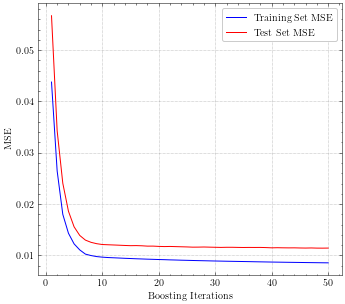

In [32]:
# 绘图
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(params['n_estimators']) + 1, mse_train, 'b-',
         label='Training Set MSE')
plt.plot(np.arange(params['n_estimators']) + 1, mse, 'r-',
         label='Test Set MSE')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('MSE')

## 4、Stacking

### 1、GBDT + LR

准备数据

In [33]:
from sklearn.datasets import load_breast_cancer
X, y = load_breast_cancer(return_X_y=True)
X.shape

(569, 30)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

构建GBDT模型：深度为2，共10棵树

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

mm = GradientBoostingClassifier(n_estimators=10, max_depth=2)
mm.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=2, n_estimators=10)

In [36]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

y_pred = mm.predict_proba(X_test)[:, 1]

print('GBDT AUC: %.5f' % roc_auc_score(y_test, y_pred))

GBDT AUC: 0.96856


获取每个点在每一棵树的索引，并将其转化为二维数组

In [37]:
X_train_leaves = mm.apply(X_train)[:, :, 0]
train_rows, cols = X_train_leaves.shape
X_test_leaves = mm.apply(X_test)[:, :, 0]

In [38]:
X_train_leaves

array([[2., 6., 2., ..., 2., 6., 3.],
       [6., 5., 6., ..., 6., 5., 6.],
       [2., 2., 2., ..., 2., 2., 2.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [6., 5., 6., ..., 6., 5., 3.],
       [2., 2., 2., ..., 2., 2., 2.]])

进行编码

>由于sklearn中的决策树索引编码规则，对于深度为2的树，其叶子结点索引的取值范围为2、3、5、6，所以可先进行LabelEncode再进行One-Hot

In [43]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories='auto')

X_trans = enc.fit_transform(
    np.concatenate((X_train_leaves, X_test_leaves), axis=0))

构建逻辑回归元模型

In [44]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='lbfgs')
lr.fit(X_trans[:train_rows, :], y_train)

y_pred_gbdtlr = lr.predict_proba(X_trans[train_rows:, :])[:, 1]

print('GBDT+LR AUC: %.5f' % roc_auc_score(y_test, y_pred_gbdtlr))

GBDT+LR AUC: 0.97019


### 2、Super Learner

#### 使用ML-Ensemble库实现Super Learner

导入

In [45]:
from mlens.ensemble import SuperLearner

[MLENS] backend: threading


实现

In [47]:
def bulid_super_learner(X,
                        y,
                        base_models,
                        meta_model,
                        score_fun,
                        kfolds=3,
                        test_size=0.3,
                        random_state=None):
                        
    '''使用ML-Ensemble库实现Super Learner'''

    # 划分数据集
    X, X_val, y, y_val = train_test_split(X,
                                          y,
                                          test_size=test_size,
                                          random_state=random_state)
    # 创建SuperLearner
    ensemble = SuperLearner(scorer=score_fun,
                            folds=kfolds,
                            shuffle=True,
                            sample_size=len(X),
                            random_state=random_state)
    # 基模型
    ensemble.add(base_models)
    # 元模型
    ensemble.add_meta(meta_model)
    # 训练集成模型
    ensemble.fit(X, y)
    # 预测
    preds = ensemble.predict(X_val)
    # 评估
    print('Super Learner Train MSE {:.3f}'.format(mean_squared_error(y_val, preds)))
    # 返回训练好的集成模型
    return ensemble

演示

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.datasets import make_regression

random_state = 42

base_models = [
    LinearRegression(),
    DecisionTreeRegressor(random_state=random_state),
    BaggingRegressor(random_state=random_state)
]
meta_model = LinearRegression()

X, y = make_regression(n_samples=1000,
                       n_features=3,
                       noise=1,
                       random_state=random_state)

ensemble = bulid_super_learner(X,
                               y,
                               base_models,
                               meta_model,
                               mean_squared_error,
                               random_state=random_state)

Super Learner Train MSE 0.975


In [53]:
pd.DataFrame(data=ensemble.data)

score-m     score-s      ft-m      ft-s  \
layer-1/baggingregressor        687.887474  110.449001  0.086001  0.007524   
layer-1/decisiontreeregressor  1262.915389  279.053603  0.023208  0.005597   
layer-1/linearregression          1.000901    0.016738  0.001275  0.000064   

                                   pt-m      pt-s  
layer-1/baggingregressor       0.005839  0.000525  
layer-1/decisiontreeregressor  0.001473  0.000841  
layer-1/linearregression       0.000222  0.000007

In [57]:
len(ensemble.layers)

2

In [56]:
ensemble.layers

[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
    name='layer-1', propagate_features=None, raise_on_exception=True,
    random_state=7270, shuffle=True,
    stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
    indexer=FoldIndex(X=None, folds=3, raise_on_exception=True),
    learners=[Learner(attr='predict', backend='threading', dtype=<class 'numpy.float32'>,
     estimator=BaggingRegressor(random_state=42),
     indexer=FoldIndex(X=None, fol...error at 0x7fdd6ec241e0>)],
    n_jobs=-1, name='group-0', raise_on_exception=True, transformers=[])],
    verbose=0),
 Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
    name='layer-2', propagate_features=None, raise_on_exception=True,
    random_state=7270, shuffle=True,
    stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
    indexer=FullIndex(X=None),
    learners=[Learner(attr='predict', backend='threading', dtype=<class 'numpy.float32'>,
     estimator=LinearRegre

### 3、Sequential Ensemble

用于集成不同集成架构的集成

例如第一层基学习期使用Subsemble集成模式，第二层使用Stack集成模式

In [10]:
from mlens.ensemble import SequentialEnsemble
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from mlens.metrics.metrics import rmse
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

X, y = load_boston(return_X_y=True)
# 划分数据集
X_train, X_val, y_train, y_val = train_test_split(X,
                                      y,
                                      test_size=0.25,
                                      random_state=42)

In [11]:
ensemble = SequentialEnsemble(scorer=rmse)
# 第1层 subsemble：3个分区和3折
ensemble.add('subsemble', [SVR(gamma='auto'), Lasso()], partitions=3, folds=3)
# 第2层 super learner: 5折
ensemble.add('stack', [SVR(gamma='auto'), Lasso()], folds=5)
# 元学习器
ensemble.add_meta(SVR(gamma='auto'))

ensemble.fit(X_train, y_train)

SequentialEnsemble(array_check=None, backend=None,
          layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=None, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=SubsetIndex(X=None, folds=3, partition...d522598>)],
   n_jobs=-1, name='group-8', raise_on_exception=True, transformers=[])],
   verbose=0)],
          model_selection=False, n_jobs=None, raise_on_exception=True,
          random_state=None, sample_size=20,
          scorer=<function rmse at 0x7fc98d522598>, shuffle=False,
          verbose=False)

In [12]:
from sklearn.metrics import mean_squared_error

preds = ensemble.predict(X_val)
print('Sequential Ensemble Train MSE {:.3f}'.format(mean_squared_error(y_val, preds)))

Sequential Ensemble Train MSE 47.337


In [4]:
import pandas as pd

pd.DataFrame(ensemble.data)

score-m   score-s      ft-m      ft-s      pt-m      pt-s
layer-1/lasso--0   6.383727  0.836645  0.015084  0.003803  0.002363  0.002918
layer-1/lasso--1   7.209599  2.350075  0.015337  0.006481  0.000277  0.000051
layer-1/lasso--2   7.071532  1.026633  0.012007  0.005876  0.000288  0.000045
layer-1/svr--0     9.332913  1.392674  0.009186  0.004499  0.006040  0.001088
layer-1/svr--1    10.316159  0.512627  0.007538  0.004429  0.006146  0.001178
layer-1/svr--2    11.260635  1.399567  0.008261  0.005178  0.004533  0.000574
layer-2/lasso--0   6.330963  1.821372  0.004923  0.003140  0.000287  0.000023
layer-2/svr--0     8.736729  2.604450  0.028403  0.006369  0.006043  0.001402